# Trabalho Prático
## Interação e Concorrência
   

### LCC  2020/2021


        Filipe Viana a85948
        Márcia Cerqueira a87992

### Exposição do problema
Considerando que cada grupo de alunos tem um número atribuído,pretendemos encontrar o nosso número numa lista usando um algoritmo quântico para encontrar s ( s = N mod 8 ).

Se este algoritmo fosse feito em computadores clássicos, teríamos de percorrer, no caso médio, metade dos elementos. No entanto, com computadores quânticos, seguindo o algoritmo de Grover, basta-nos apenas percorrer 1 elemento.


### 1. Divisão do algoritmo em secções. Simulação do estado de cada secção do algoritmo e explicação de cada etapa ( atenção especial ao oráculo).

O algoritmo de Grover permite encontrar um número numa lista não ordenada.
1. Inicializar o circuito com todos os estados possíveis com a mesma amplitude.

2. Repetir os seguintes passos $\sqrt s $ vezes:

    1.Aplicar o oráculo -> este vai inverter o sinal do número que estamos à procura;
    
    2.Aplicar o difusor -> este vai inverter de novo o sinal do número que estamos À procura e aumentar a sua amplitude;
    
3. Medir os estados quânticos resultantes.

In [1]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import *
from qiskit.providers.ibmq import least_busy
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt

Considerando que pertencemos ao grupo 6, primeiramente precisámos de calcular s.

In [2]:
backend_statevector = Aer.get_backend('statevector_simulator')
backend_qasm_sim = Aer.get_backend("qasm_simulator")

In [3]:
backend_statevector

StatevectorSimulator('statevector_simulator')

In [4]:
s = 6 % 8
s

6

De seguida iremos converter para binário.

In [5]:
sb = bin(s)[2:] 
print('Número em binário:',sb)

Número em binário: 110


Número de qubits necessários para o circuito:

In [6]:
x = len(sb)
print( 'Número de quibts: ',x)

Número de quibts:  3


Precisaremos de 3 quibts uma vez que 6 é representado em binário por 3 bits. Vamos criar um circuito com 3 quibts e iniciá-lo com Hadamard gates para criar sobreposição uniforme, ou seja, uma sobreposição linear de estados onde todos os auto-estados apresentam a mesma amplitude de probabilidade.

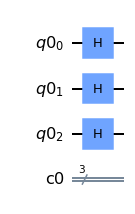

In [7]:
qr = QuantumRegister(3,)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)
for i in range(3):
    qc.h(i)
qc.draw(output='mpl')

### Simulação do estado do vetor

Iremos criar o oráculo de mudança de fase, para isso, temos de aplicar as portas CCZ, uma vez que esta não existem em Quiskit, temos de aplicar a combinação equivalente: H CCX H.

In [8]:
def simulate_circuit(qc):

    global backend_statevector

    result = execute(qc, backend_statevector).result()
    statevector = result.get_statevector(qc)
    return statevector

In [9]:
def select_w(circuit, qr_x):
    circuit.x(qr_x[0])
    
    
#oracle to change phase |110>
def phase_oracle(circuit, qr_x):
    
     select_w(circuit, qr_x)

#HXH - Controlled Z
     circuit.h(0)
     circuit.ccx(2, 1, 0)
     circuit.h(0)
    
#voltar aos qubits iniciais
     select_w(circuit, qr_x)

De seguida é necessário fazer a amplificação, este passo serve para o computador quântico realçar a probabilidade do elemento desejado, amplificando a sua amplitude. Para isso, vai inverter todos os estados menos o que pretendemos e vai amplificar o pretendido.
Temos de aplicar as portas X a todos os quibts para inverter o efeito da porta CCZ (inverter a fase em 000 e não em 111), como implementado anteriormente no oráculo.

In [10]:
def diffuser(circuit, qr_x):

     circuit.h(qr_x)
     circuit.x(qr_x)

    # HXH - Controlled Z
     circuit.h(0)
     circuit.ccx(2, 1, 0)
     circuit.h(0) 

     circuit.x(qr_x)
     circuit.h(qr_x)

### Inicialização

In [11]:
qc = QuantumCircuit(3, 3)
qc.h(0)
qc.h(1)
qc.h(2)
qc_sim = simulate_circuit(qc)

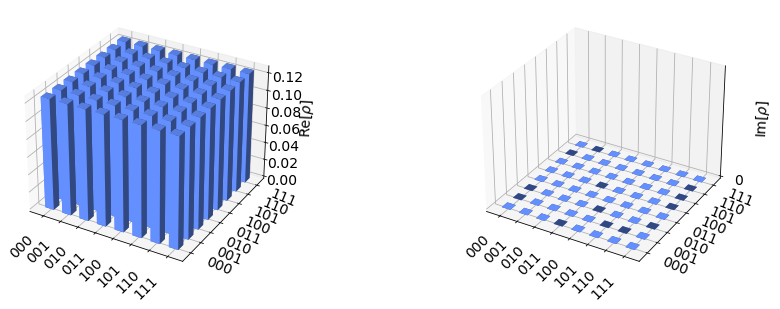

In [12]:
plot_state_city(qc_sim)


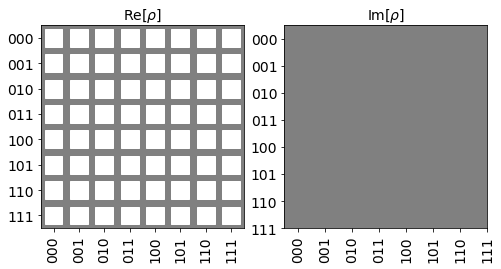

In [13]:
plot_state_hinton(qc_sim)

### Aplicação do oráculo 

In [14]:
qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')
qc = QuantumCircuit(qr, cr)
# Inicialização
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
# Aplicação do Oráculo
phase_oracle(qc, qr)
qc_sim = simulate_circuit(qc)


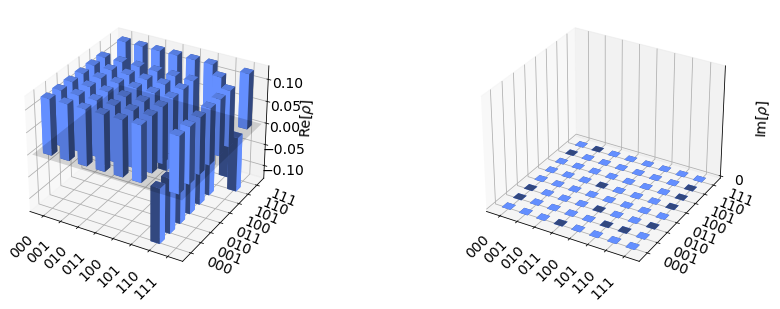

In [15]:
plot_state_city(qc_sim)

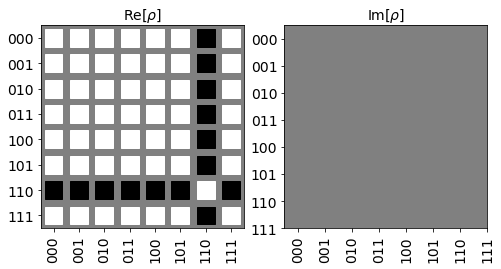

In [16]:
plot_state_hinton(qc_sim)

### Aplicação do difusor

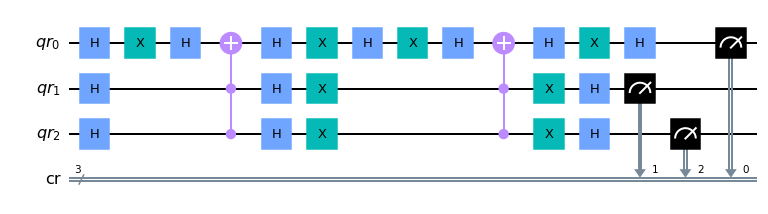

In [17]:
qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')
qc = QuantumCircuit(qr, cr)
# Inicialização
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
# Aplicação do Oráculo
phase_oracle(qc, qr)
# Aplicação do difusor
diffuser(qc, qr)
qc.measure(qr, cr)
qc_sim = simulate_circuit(qc)
qc.draw(output='mpl')

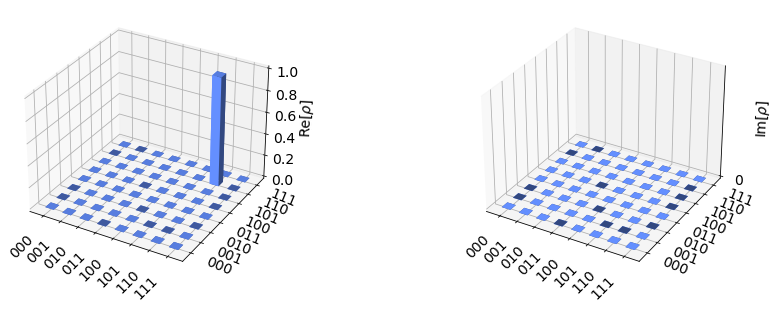

In [18]:
plot_state_city(qc_sim)

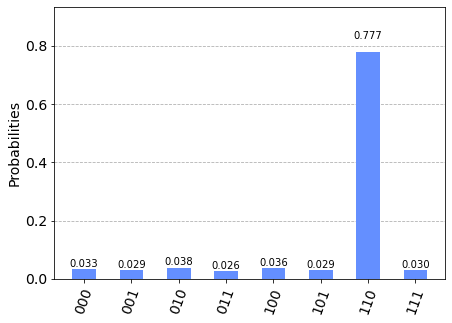

In [19]:
shots=1024
job = execute(qc, backend_qasm_sim, shots=1024)
result = job.result()
counts_sim = result.get_counts()
plot_histogram(counts_sim)


### Medição de quibts

In [20]:
import math
math.floor(math.sqrt(2**3))

2

In [21]:
qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')
qc = QuantumCircuit(qr, cr)
# Inicialização
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
for t in range(2):
 # Aplicação do Oráculo
 phase_oracle(qc, qr)
 # Aplicação do difusor
 diffuser(qc, qr)
qc.measure(qr, cr)
qc_sim = simulate_circuit(qc)


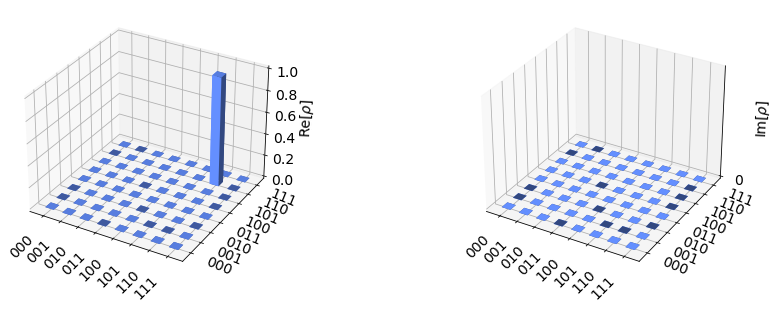

In [22]:
plot_state_city(qc_sim)

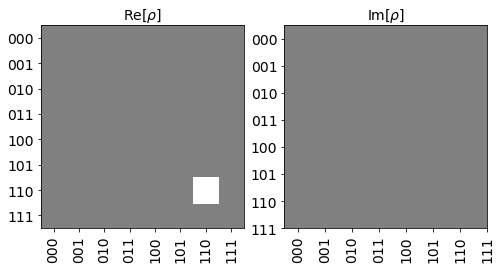

In [23]:
plot_state_hinton(qc_sim)

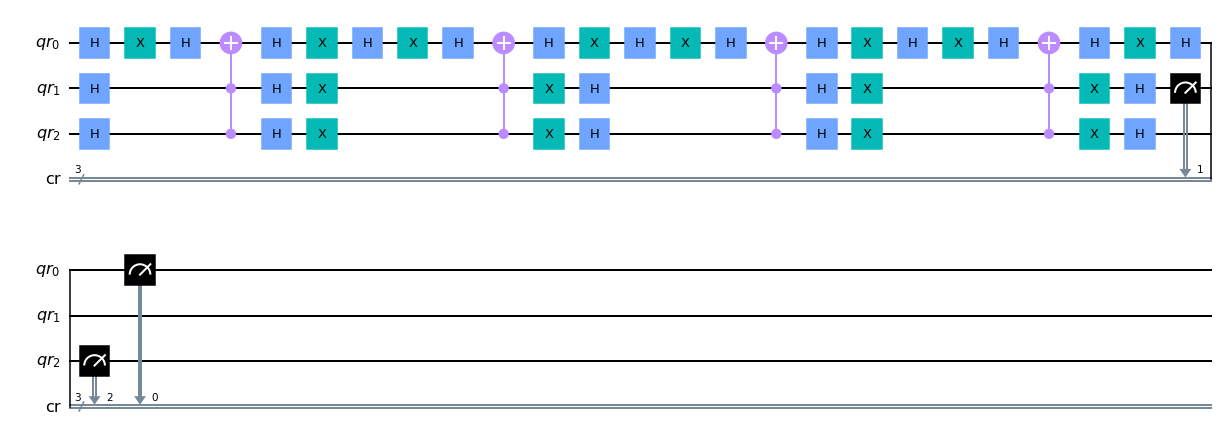

In [24]:
qc.draw(output='mpl')

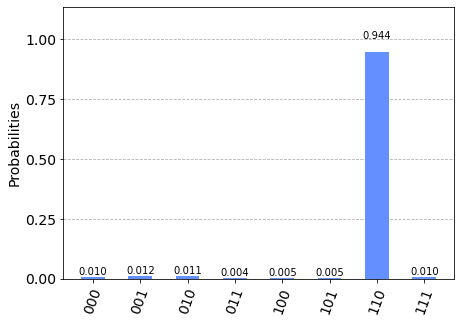

In [25]:
shots=1024
job = execute(qc, backend_qasm_sim, shots=1024)
result = job.result()
counts_sim = result.get_counts()
plot_histogram(counts_sim)

### 2. Determinação da melhor otimização utilizando ruído.

Vamos usar modelos de simulação de ruído do Aer para prever qual é a melhor optimização a fazer ao algoritmo.

Primeiramente iremos começar por escolher uma máquina para obter um modelo de ruído de acordo com as características da mesma. Para isso, vamos primeiro ver as informações de cada uma.

In [26]:
#Login na conta IBM
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [27]:
# Backend overview
import qiskit.tools.jupyter

%qiskit_backend_overview

Optámos por escolher a simulação com a ibmq_athens, uma vez que o erro médio de medição é menor.

In [28]:
# selecionar em que máquina vamos executar o circuito
my_provider_ibmq = IBMQ.get_provider(hub='ibm-q', group='open', project='main') 

# Define backend
backend_device = my_provider_ibmq.get_backend('ibmq_athens')

# See backend information
backend_device


<IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>

In [29]:
coupling_map = backend_device.configuration().coupling_map

from qiskit.providers.aer.noise import NoiseModel

#construção do modelo de ruído apartir das propriedades do backend device
noise_model = NoiseModel.from_backend(backend_device)

#adquirir os gates para o modelo de ruído construído anteriormente 
basis_gates = noise_model.basis_gates
print(basis_gates)

['cx', 'id', 'reset', 'rz', 'sx', 'x']


Começamos por executar o modelo de ruído no primeiro circuito

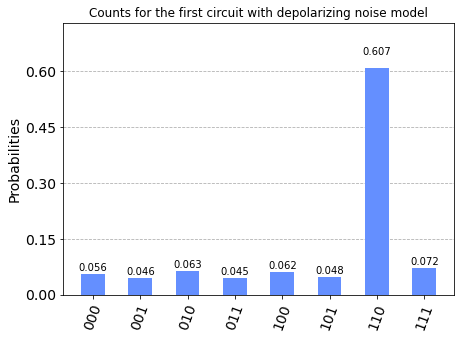

In [30]:
#execução de uma simulação com ruído
result_noise = execute(qc, backend_qasm_sim, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(qc)
plot_histogram(counts_noise, title="Counts for the first circuit with depolarizing noise model")

In [31]:
print(counts_sim)

{'110': 967, '011': 4, '010': 11, '101': 5, '000': 10, '111': 10, '001': 12, '100': 5}


In [32]:
print(counts_noise)

{'001': 47, '110': 622, '100': 64, '000': 57, '010': 65, '111': 74, '101': 49, '011': 46}


Podemos agora obter as probabilidades de obter cada estado

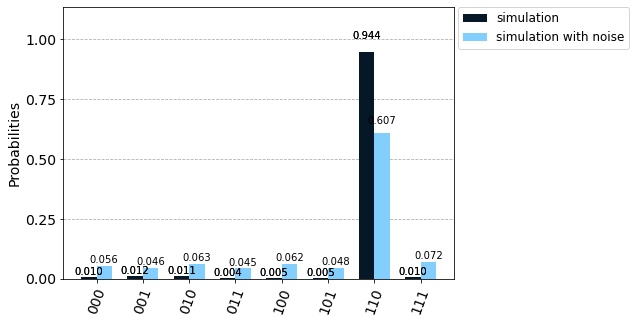

In [60]:
def resume(counts_raw):
    s000 = s001 = s010 = s011 = s100 = s101 = s110 = s111 = 0
    k = counts_raw.keys()
    lk=list(k)
    for c in lk:
        if c == '000':
            s000 = s000 + counts_raw.get(c)
        elif c == '001':
            s001 = s001 + counts_raw.get(c)
        elif c == '010':
            s010 = s010 + counts_raw.get(c)
        elif c == '011':
            s011 = s011 + counts_raw.get(c)
        elif c == '100':
            s100 = s100 + counts_raw.get(c)
        elif c == '101':
            s101 = s101 + counts_raw.get(c)
        elif c == '110':
            s110 = s110 + counts_raw.get(c)
        else:
            s111 = s111 + counts_raw.get(c)
    return({'000': s000, '001': s001, '010': s010, '011': s011, '100': s100,'101': s101, '110': s110, '111': s111})


cn = resume(counts_noise)
c = resume(counts_sim)

plot_histogram([c,cn], legend= ['simulation','simulation with noise'], color=['#061727','#82cfff'])

### 3. Utilizando IBM Q

Nesta questão pretende-se executar o algoritmo no IBM Q. O primeiro passo, consiste em carregar o nosso IBM Q Experience.

In [35]:
from qiskit.tools.monitor import backend_overview, backend_monitor

#backend_overview()

Pretendemos usar a máquina quântica de Santiago

In [36]:
backend_device = provider.get_backend('ibmq_athens')
print("Running on: ", backend_device)

Running on:  ibmq_athens


In [37]:
#backend_device

In [38]:
#backend_monitor(backend_device)

In [39]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [40]:
job_r = execute(qc, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60bcf95ebce7724484ef9710


In [41]:
job_get=backend_device.retrieve_job("60bcf95ebce7724484ef9710")

job_get.error_message()

In [42]:
result_r = job_get.result()
counts_run = result_r.get_counts()

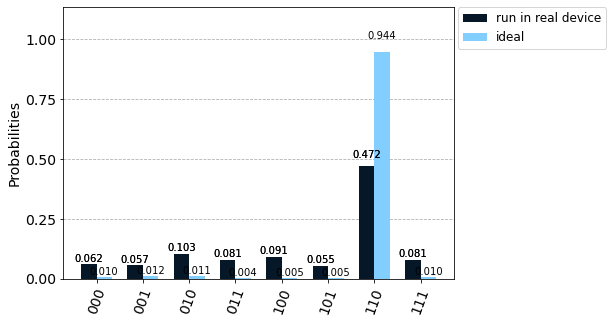

In [43]:
plot_histogram([counts_run, counts_sim ], legend=[ 'run in real device', 'ideal'], 
               color=['#061727','#82cfff'])

Pretendemos agora obter uma optização do circuito e, por isso, decidimos optar pela otimização de nível 2.

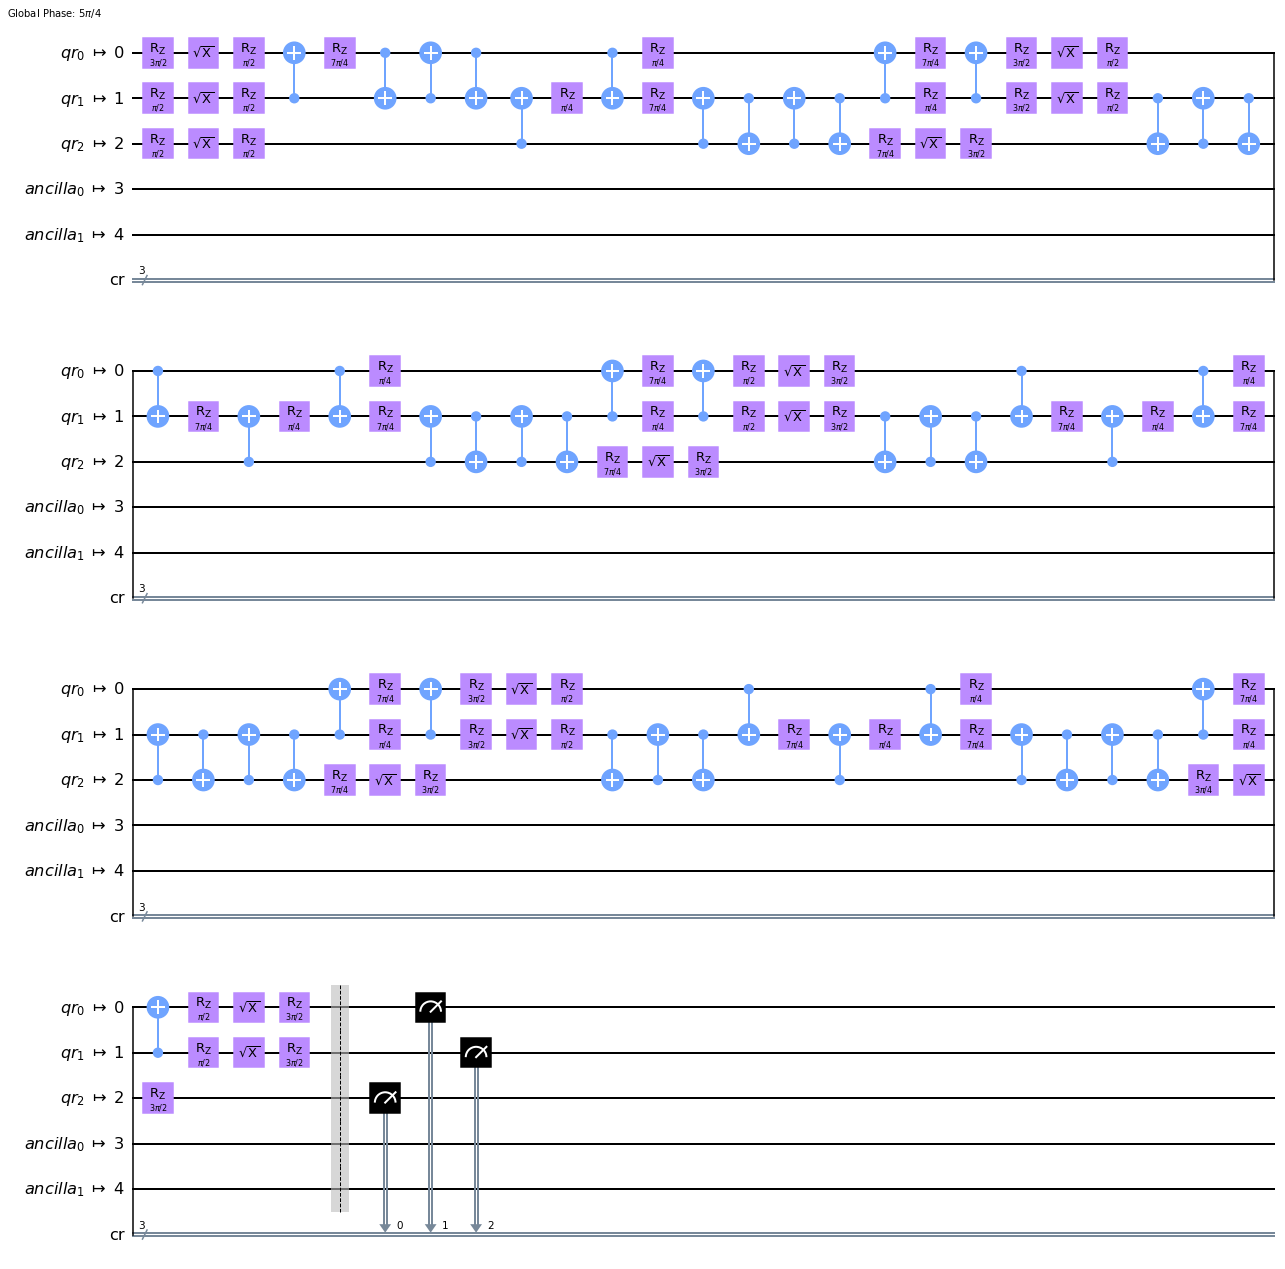

In [44]:
#optimizaçao

qc_t_real = transpile(qc, backend=backend_device)

qc_t_real.draw(output='mpl')

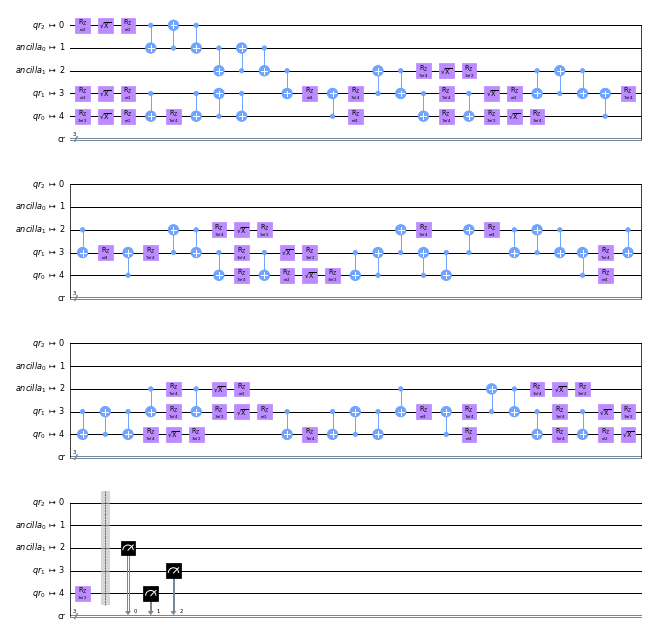

In [45]:
qc_optimized = transpile(qc, backend=backend_device, optimization_level=2)
qc_optimized.draw(output='mpl', scale=0.5)

In [46]:
qc_optimized.depth()


77

In [47]:
qc_t_real.depth()

80

In [48]:
job_exp = execute(qc_optimized, backend_device, shots = shots)

# job_id allows you to retrive old jobs
jobID = job_exp.job_id()
job_exp.result().get_counts(qc_optimized)
print('JOB ID: {}'.format(jobID))


JOB ID: 60bcf9e900aded3d616a7e20


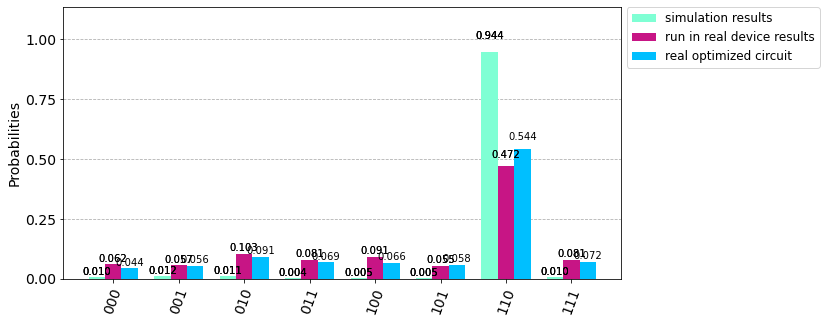

In [49]:
job_get_o=backend_device.retrieve_job("60bcf9e900aded3d616a7e20")

result_real_o = job_get_o.result(timeout=3600, wait=5)

counts_opt = result_real_o.get_counts(qc_optimized)


legend = [ 'simulation results','run in real device results', 'real optimized circuit']
color = ['aquamarine','mediumvioletred','deepskyblue']

plot_histogram([counts_sim, counts_run, counts_opt], legend = legend,  color=color, figsize=(10, 5))

### 4. Tratamento de erros utilizando Ignis

O objetivo desta questão é proceder ao tratamento de erros, recorrendo ao módulo Ignis.

In [50]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

Iremos gerar uma lista de circuitos de calibração de medição para todo o espaço de Hilbert. Neste caso, como temos 3 qubits, então obtemos 8 circuitos de calibração.

In [51]:
# Generate the calibration circuits
qr = QuantumRegister(x)

# meas_calibs:
# list of quantum circuit objects containing the calibration circuits
# state_labels:
# calibration state labels
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [52]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

Vamos  agora executar no circuito de calibração recorrendo ao IBM_Q, neste caso, por ser uma máquina real, vamos obter ruído e por isso a matriz não será a identidade.

In [53]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60bcfa52b454d0705eaa75f5


In [54]:
job_get2=backend_device.retrieve_job("60bcfa52b454d0705eaa75f5")

cal_results = job_get2.result()

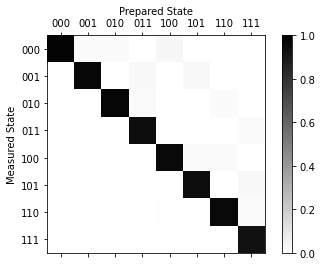

In [55]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

In [56]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.957764


Podemos aplicar um filtro com base na matriz de calibração para obter contagens mitigadas.

In [57]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

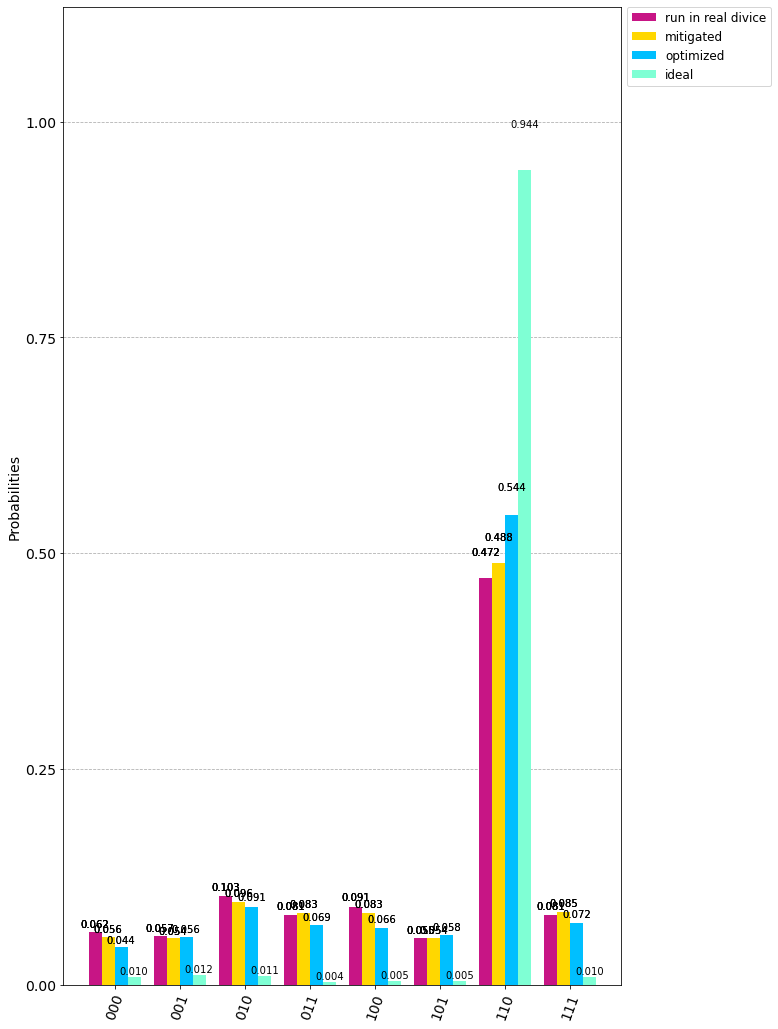

In [58]:
color = ['mediumvioletred','gold','deepskyblue','aquamarine']
plot_histogram([counts_run, mitigated_counts,counts_opt,counts_sim], legend=['run in real divice', 'mitigated','optimized', 'ideal'],color=color,figsize=(10, 18))